# Prosper Loan data exploration
## by Andy Watson

## Preliminary Wrangling

Little wrangling is needed.
Udacity provided us with a clean csv file from Prosper Financials.
But we will change the ListingCreationDate column from object to datetime format.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [3]:
loan = pd.read_csv('prosperLoanData.csv')

In [4]:
loan['ListingCreationDate'] = pd.to_datetime(loan['ListingCreationDate'])

In [5]:
loans_to_2008 = (loan[loan['ListingCreationDate'].dt.year <= 2008]).copy()

In [6]:
loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 

### What is the structure of your dataset?

The file contains data on 113,937 loans (rows) with 81 variables (columns). 

Variables include loan amount, interest rate, information about borrower's financial history, and current loan status. 

The data was last updated 2014.

### What is/are the main feature(s) of interest in your dataset?

My goal here is to find variables that can accurately predict a loan's outcome. 

In order to make the project manageable, I will restrict my focus to information about the borrower.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

#### Quantitative Variables:

I expect the borrower's credit rating score to accurately predict loan outcomes. This rating is created by financial institutions to assess a borrower's credit risk based on current and historical financial data about the borrower. 

Borrower income range, debt to income ratio, and current and past delinquincies should also correlate strongly with loan outcomes.

I am also curious about the number of investors variable and the effect of loan term on loan outcomes.

#### Categorical Variables:

I will also explore two categorical variables: borrower's state, and borrower occupation.

#### Loan outcome data

The loan outcome data is the current status of the loan: 

Cancelled,  Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.

In order to compare likes to likes and to avoid comparing new loans with older ones (the new ones will of course have a much lower default rate), I will choose a few loan terms and look at their current status data from the beginning of the loan term up through one year after the loan term was originally set to expire. This should render outcomes that are mostly either Cancelled, Charged Off, Completed or Defaulted.

## Preliminary Investigation of Data 

In [4]:
loan.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [5]:
loan.info

<bound method DataFrame.info of                      ListingKey  ListingNumber     ListingCreationDate  \
0       1021339766868145413AB3B         193129 2007-08-26 19:09:29.263   
1       10273602499503308B223C1        1209647 2014-02-27 08:28:07.900   
2       0EE9337825851032864889A          81716 2007-01-05 15:00:47.090   
3       0EF5356002482715299901A         658116 2012-10-22 11:02:35.010   
4       0F023589499656230C5E3E2         909464 2013-09-14 18:38:39.097   
...                         ...            ...                     ...   
113932  E6D9357655724827169606C         753087 2013-04-14 05:55:02.663   
113933  E6DB353036033497292EE43         537216 2011-11-03 20:42:55.333   
113934  E6E13596170052029692BB1        1069178 2013-12-13 05:49:12.703   
113935  E6EB3531504622671970D9E         539056 2011-11-14 13:18:26.597   
113936  E6ED3600409833199F711B7        1140093 2014-01-15 09:27:37.657   

       CreditGrade  Term              LoanStatus           ClosedDate  \
0     

In [9]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

In [32]:
# show right side of dataframe
loan_right = loan.iloc[0:1000, 63:76].copy()
loan_right.head()

,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments
0,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0
1,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0
3,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0
4,15000,2013-09-20 00:00:00,Q3 2013,36CE356043264555721F06C,563.97,2819.85,1563.22,1256.63,-60.27,0.0,0.0,0.0,0.0


In [31]:
# show instances where the debth was charged off
loan_right[loan_right['LP_NonPrincipalRecoverypayments'] > 0].head()

,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments
17,10000,2006-08-22 00:00:00,Q3 2006,893E3365582060699EBBADA,334.54,5325.33,3987.33,1338.00,-54.61,0.00,6012.65,6012.67,268.96
103,15000,2012-04-19 00:00:00,Q2 2012,F11E34621201188152DD3DA,579.63,3968.89,1119.05,2849.84,-49.41,-813.65,13880.95,13880.95,1600.00
138,3000,2012-03-21 00:00:00,Q1 2012,87C83528199783859742DC3,127.34,127.34,23.82,103.52,-5.90,0.00,2976.18,0.00,764.27
185,6000,2010-08-09 00:00:00,Q3 2010,367B348955246532073DD98,234.30,3748.80,2155.59,1593.21,-67.39,0.00,3844.41,3844.41,685.00
251,17500,2006-11-13 00:00:00,Q4 2006,AE023364899153293DA6164,614.64,17565.17,13663.22,3901.95,-106.75,-1106.34,3842.60,2221.08,889.34


In [6]:
loan.value_counts()

Series([], dtype: int64)

In [7]:
loan.describe()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,1.139370e+05,113937.000000,113912.000000,113937.000000,113937.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,...,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000
mean,6.278857e+05,40.830248,0.218828,0.192764,0.182701,0.168661,0.080306,0.096068,4.072243,5.950067,...,-54.725641,-14.242698,700.446342,681.420499,25.142686,0.998584,0.048027,0.023460,16.550751,80.475228
std,3.280762e+05,10.436212,0.080364,0.074818,0.074516,0.068467,0.046764,0.030403,1.673227,2.376501,...,60.675425,109.232758,2388.513831,2357.167068,275.657937,0.017919,0.332353,0.232412,294.545422,103.239020
min,4.000000e+00,12.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,...,-664.870000,-9274.750000,-94.200000,-954.550000,0.000000,0.700000,0.000000,0.000000,0.000000,1.000000
25%,4.009190e+05,36.000000,0.156290,0.134000,0.124200,0.115670,0.042400,0.074080,3.000000,4.000000,...,-73.180000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,6.005540e+05,36.000000,0.209760,0.184000,0.173000,0.161500,0.072400,0.091700,4.000000,6.000000,...,-34.440000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,44.000000
75%,8.926340e+05,36.000000,0.283810,0.250000,0.240000,0.224300,0.112000,0.116600,5.000000,8.000000,...,-13.920000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,115.000000
max,1.255725e+06,60.000000,0.512290,0.497500,0.492500,0.319900,0.366000,0.283700,7.000000,11.000000,...,32.060000,0.000000,25000.000000,25000.000000,21117.900000,1.012500,39.000000,33.000000,25000.000000,1189.000000


In [8]:
loan['LoanStatus']

0                      Completed
1                        Current
2                      Completed
3                        Current
4                        Current
                   ...          
113932                   Current
113933    FinalPaymentInProgress
113934                   Current
113935                 Completed
113936                   Current
Name: LoanStatus, Length: 113937, dtype: object

In [9]:
loan.groupby('LoanStatus').describe()

ListingNumber                                          \
                               count           mean            std       min   
LoanStatus                                                                     
Cancelled                        5.0   87767.200000  180178.635718     908.0   
Chargedoff                   11992.0  364864.921364  197898.726241     156.0   
Completed                    38074.0  388419.870121  213516.255126       4.0   
Current                      56576.0  876833.378199  210349.150769  464139.0   
Defaulted                     5018.0  232427.769829  189488.459787      99.0   
FinalPaymentInProgress         205.0  747528.004878  202541.470503  489610.0   
Past Due (1-15 days)           806.0  710421.168734  163273.523789  471640.0   
Past Due (16-30 days)          265.0  703710.335849  150930.601944  492772.0   
Past Due (31-60 days)          363.0  712121.658402  154116.557782  491495.0   
Past Due (61-90 days)          313.0  690544.562300  136034.292526  488826.0   
Past Due (91-120 days)         304.0  669112.799342  120903.929615  482134.0   
Past Due (>120 days)            16.0  649402.625000  111548.326149  517786.0   

                                                                       Term  \
                              25%       50%         75%        max    count   
LoanStatus                                                                    
Cancelled                 7646.00    8912.0    11364.00   410006.0      5.0   
Chargedoff              188513.75  369917.0   534035.50   932346.0  11992.0   
Completed               221154.50  425475.5   529267.50  1204824.0  38074.0   
Current                 694592.50  883436.0  1057011.50  1255725.0  56576.0   
Defaulted                69063.75  178389.0   367876.25  1099553.0   5018.0   
FinalPaymentInProgress  569532.00  719603.0   908166.00  1240719.0    205.0   
Past Due (1-15 days)    575699.50  662199.5   830913.00  1184124.0    806.0   
Past Due (16-30 days)   588835.00  668132.0   801508.00  1123445.0    265.0   
Past Due (31-60 days)   583373.00  665787.0   840125.00  1112078.0    363.0   
Past Due (61-90 days)   591478.00  651766.0   788166.00  1069344.0    313.0   
Past Due (91-120 days)  573197.50  640280.0   765599.25  1016433.0    304.0   
Past Due (>120 days)    548950.25  630783.5   766740.50   829185.0     16.0   

                                   ... InvestmentFromFriendsAmount            \
                             mean  ...                         75%       max   
LoanStatus                         ...                                         
Cancelled               36.000000  ...                         0.0      0.00   
Chargedoff              38.029353  ...                         0.0  12500.00   
Completed               36.613962  ...                         0.0  25000.00   
Current                 44.511736  ...                         0.0   3000.00   
Defaulted               36.841770  ...                         0.0   8200.00   
FinalPaymentInProgress  39.278049  ...                         0.0    250.00   
Past Due (1-15 days)    43.354839  ...                         0.0    845.00   
Past Due (16-30 days)   43.698113  ...                         0.0    525.58   
Past Due (31-60 days)   44.066116  ...                         0.0      0.00   
Past Due (61-90 days)   43.974441  ...                         0.0      0.00   
Past Due (91-120 days)  44.605263  ...                         0.0      0.00   
Past Due (>120 days)    46.500000  ...                         0.0      0.00   

                       Investors                                            \
                           count        mean         std  min    25%   50%   
LoanStatus                                                                   
Cancelled                    5.0   24.600000   22.678183  6.0   7.00  23.0   
Chargedoff               11992.0   96.110657  102.788349  1.0  28.00  61.0   
Completed                38074.0  108.223854 

In [24]:
loan.groupby('LoanStatus').mean()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
LoanStatus,,,,,,,,,,,,,,,,,,,,,
Cancelled,87767.200000,36.000000,0.205826,0.184400,0.178400,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,24.600000
Chargedoff,364864.921364,38.029353,0.257752,0.235397,0.224656,0.218423,0.116322,0.123379,2.882871,5.390742,...,-46.863075,-49.842038,4662.518525,4608.299671,136.912133,0.997808,0.085474,0.036191,32.136696,96.110657
Completed,388419.870121,36.613962,0.208781,0.186422,0.176595,0.163086,0.086753,0.102430,3.907648,6.536513,...,-57.650019,-5.104060,0.000000,0.000000,0.000000,0.998702,0.092452,0.051584,36.283888,108.223854
Current,876833.378199,44.511736,0.213740,0.183771,0.173771,0.163595,0.073381,0.090227,4.288426,5.837952,...,-55.021413,-1.852073,0.000000,0.000000,0.000000,0.998664,0.009191,0.002209,0.585536,57.140148
Defaulted,232427.769829,36.841770,0.238925,0.223077,0.212097,0.209420,0.111961,0.123416,3.015920,5.619900,...,-39.681192,-116.638448,4761.624705,4459.202419,243.689113,0.999261,0.075528,0.028298,16.612698,100.659426
FinalPaymentInProgress,747528.004878,39.278049,0.229558,0.196960,0.186960,0.176569,0.083253,0.093316,3.956098,5.751220,...,-68.433366,-4.627024,0.000000,0.000000,0.000000,0.996479,0.009756,0.014634,2.560878,76.751220
Past Due (1-15 days),710421.168734,43.354839,0.263828,0.230797,0.220797,0.208204,0.097967,0.110621,3.373449,5.042184,...,-79.069007,-72.582581,0.000000,0.000000,0.000000,0.997539,0.014888,0.002481,1.166253,66.997519
Past Due (16-30 days),703710.335849,43.698113,0.268445,0.235258,0.225258,0.211939,0.100970,0.110969,3.275472,4.969811,...,-74.676415,-83.735585,0.000000,0.000000,0.000000,0.997878,0.011321,0.011321,3.517283,73.509434
Past Due (31-60 days),712121.658402,44.066116,0.265734,0.232978,0.222978,0.210208,0.099552,0.110655,3.327824,5.110193,...,-70.067135,-64.730523,0.000000,0.000000,0.000000,0.997508,0.013774,0.000000,0.000000,62.652893


In [25]:
loan.groupby('Term').describe()

ListingNumber                                                     \
             count           mean            std       min        25%   
Term                                                                    
12          1614.0  596105.513631   74617.647800  319654.0  534315.75   
36         87778.0  569803.789663  335151.727576       4.0  315996.00   
60         24545.0  837688.360114  203513.631937  464735.0  653639.00   

                                      BorrowerAPR            ...  \
           50%         75%        max       count      mean  ...   
Term                                                         ...   
12    589994.5   658609.25   741982.0      1614.0  0.216223  ...   
36    534666.5   841837.75  1255725.0     87753.0  0.219431  ...   
60    827167.0  1009196.00  1255149.0     24545.0  0.216843  ...   

     InvestmentFromFriendsAmount           Investors                         \
                             75%       max     count       mean         std   
Term                                                                          
12                           0.0   2975.00    1614.0  65.087980   64.473477   
36                           0.0  25000.00   87778.0  83.671227  104.153692   
60                           0.0  10593.67   24545.0  70.057486  101.229366   

                                       
      min    25%   50%    75%     max  
Term                                   
12    1.0  29.25  47.0   75.0   504.0  
36    1.0   7.00  48.0  117.0  1189.0  
60    1.0   1.00  17.0  112.0   714.0  

[3 rows x 480 columns]

In [26]:
loan.groupby('Term').mean()

,ListingNumber,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
Term,,,,,,,,,,,,,,,,,,,,,
12,596105.513631,0.216223,0.150081,0.140081,0.134658,0.074130,0.060680,4.326100,6.563546,4.915737,...,-21.124318,-8.580409,138.233482,128.697193,2.100372,0.999077,0.048947,0.014250,4.907200,65.087980
36,569803.789663,0.219431,0.193486,0.183404,0.167792,0.084158,0.094762,3.965397,5.868115,2.684294,...,-50.221543,-16.660683,772.827297,749.617007,31.304558,0.998857,0.058625,0.029506,21.047365,83.671227
60,837688.360114,0.216843,0.192991,0.182990,0.172976,0.071499,0.101517,4.311061,6.105724,2.954940,...,-73.042744,-5.967816,478.566374,473.880975,4.621747,0.997574,0.010063,0.002444,1.235570,70.057486


In [36]:
loan['ListingCreationDate'].dtype

dtype('O')

In [4]:
years = loan.ListingCreationDate.apply(lambda x: x[:4])
print(years)

0         2007
1         2014
2         2007
3         2012
4         2013
          ... 
113932    2013
113933    2011
113934    2013
113935    2011
113936    2014
Name: ListingCreationDate, Length: 113937, dtype: object


In [4]:
loan.groupby('ListingCreationDate').apply(lambda x: x[:4])

KeyboardInterrupt: 

In [4]:
dates_loan = loan.copy()

In [5]:
dates_loan['ListingCreationDate']  = dates_loan['ListingCreationDate'].dt.year

In [6]:
dates_loan.groupby('ListingCreationDate').count()


,ListingKey,ListingNumber,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
ListingCreationDate,,,,,,,,,,,,,,,,,,,,,
2005,23,23,23,23,23,23,0,23,23,0,...,23,23,23,23,23,23,23,23,23,23
2006,6213,6213,6213,6213,6213,6213,6211,6213,6213,0,...,6213,6213,6213,6213,6213,6213,6213,6213,6213,6213
2007,11557,11557,11544,11557,11557,11557,11557,11557,11557,0,...,11557,11557,11557,11557,11557,11557,11557,11557,11557,11557
2008,11263,11263,11160,11263,11263,11263,11263,11263,11263,0,...,11263,11263,11263,11263,11263,11263,11263,11263,11263,11263
2009,2206,2206,13,2206,2206,2206,2206,2206,2206,2178,...,2206,2206,2206,2206,2206,2206,2206,2206,2206,2206
2010,5530,5530,0,5530,5530,5489,5530,5530,5530,5530,...,5530,5530,5530,5530,5530,5530,5530,5530,5530,5530
2011,11442,11442,0,11442,11442,7700,11442,11442,11442,11442,...,11442,11442,11442,11442,11442,11442,11442,11442,11442,11442
2012,19556,19556,0,19556,19556,8032,19556,19556,19556,19556,...,19556,19556,19556,19556,19556,19556,19556,19556,19556,19556
2013,35413,35413,0,35413,35413,2544,35413,35413,35413,35413,...,35413,35413,35413,35413,35413,35413,35413,35413,35413,35413


## Univariate Exploration

First: What is the distribution of loan outcomes?



<AxesSubplot:xlabel='count', ylabel='LoanStatus'>

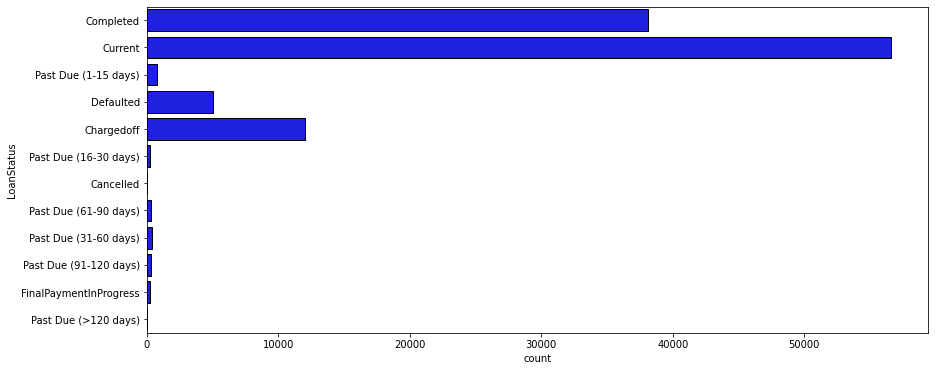

In [9]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loan, y='LoanStatus', color='blue', edgecolor='black')

The Completed category dwarfs all other categories.

So I will see what happens with a log transformation

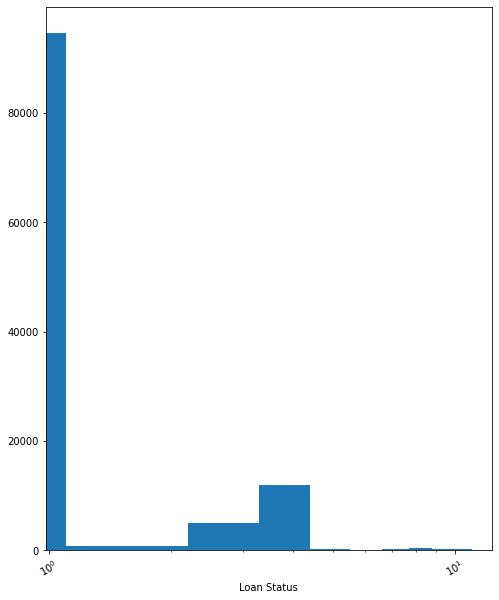

In [24]:
# never mind this part

# the completed dwarfs all other categories
# So I will see what happens with a log transformation
plt.figure(figsize=[8, 10])
plt.hist(data = loan, x = 'LoanStatus')
plt.xlabel('Loan Status')
plt.xscale('log')
plt.xticks(rotation=30)
plt.show()


OK, that didn't change anything.

I think I should limit my investigations to 2008.

Because all those loans terms should've been completed by 2014 (the longest term is 5 years and 2013-5=2008).

In [21]:
loans_to_2008 = (loan[loan['ListingCreationDate'].dt.year <= 2008]).copy()

<AxesSubplot:xlabel='count', ylabel='LoanStatus'>

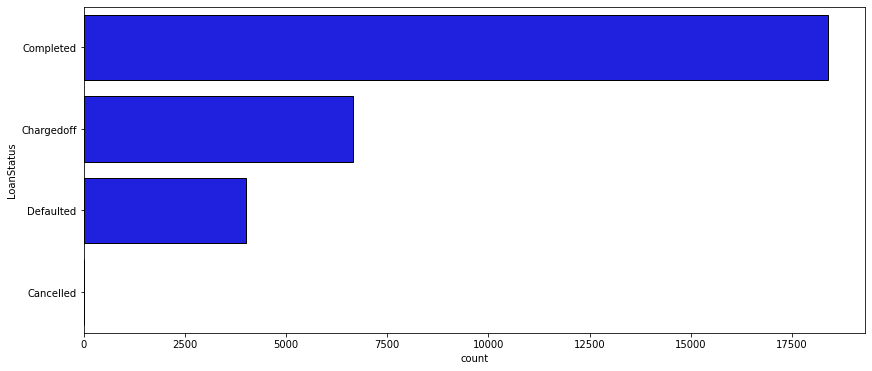

In [4]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loans_to_2008, y='LoanStatus', color='blue', edgecolor='black')

In [13]:
loans_to_2008[loans_to_2008['LoanStatus'] == 'Cancelled'].count()

ListingKey                     5
ListingNumber                  5
ListingCreationDate            5
CreditGrade                    5
Term                           5
                              ..
PercentFunded                  5
Recommendations                5
InvestmentFromFriendsCount     5
InvestmentFromFriendsAmount    5
Investors                      5
Length: 81, dtype: int64

I looked at the loans created from 2005 to 2008. 

All of those loans's original terms were up by 2014, when the stopped updating our data. Most were completed, but a significate number where charged off or defaulted. Only 5 loans were cancelled. 

Default status is generally declared when a loan is 121 past due. The loan is generally charged off (ie: all hope is abandoned for the recovery of the debt) after 150 days past due. 

It is strange that there's so many loans that are still lingering in Defaulted. 

I should check to see what percentage of the defaulted loans are 5-year loans from 2008. But first I want to look at the above data in terms of percentages.

In [14]:
loans_to_2008.LoanStatus.value_counts()

Completed     18385
Chargedoff     6654
Defaulted      4012
Cancelled         5
Name: LoanStatus, dtype: int64

In [15]:
loans_to_2008.LoanStatus.value_counts().sum()

29056

<Figure size 1008x432 with 0 Axes>

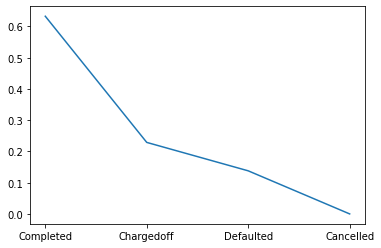

In [21]:
# find the total number of loans created from 2005 through 2008
total = loans_to_2008.LoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.LoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.LoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.plot(category, percentage)

<BarContainer object of 4 artists>

<Figure size 1008x432 with 0 Axes>

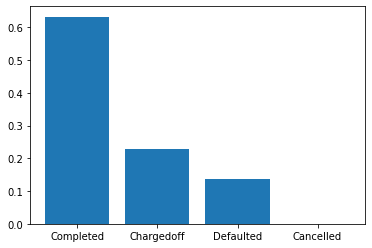

In [22]:
# I think it is easier to see with a bar chart

# find the total number of loans created from 2005 through 2008
total = loans_to_2008.LoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.LoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.LoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.bar(category, percentage)

In [25]:
# I want to know what percent of the Defaulted loans are five year loans
loans_to_2008.groupby('Term').sum()

,ListingNumber,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
Term,,,,,,,,,,,,,,,,,,,,,
12,319654,0.23135,0.08200,0.0720,0.0,0.0,0.0,0.0,0.0,7,...,-5.09,0.0000,0.00,0.000000e+00,0.00,1.000,0,1,100.00,105
36,5861854010,5688.81977,5325.23955,5027.9006,0.0,0.0,0.0,0.0,0.0,34899,...,-1597901.02,-926460.7657,47894492.13,4.643645e+07,2215805.94,29055.011,3978,1989,1519454.88,3373619


So all these loans were supposed to be paid in either one or three years.

I don't understand how any could still be in the Defaulted, rather than the ChargedOff category in 2014.

I guess these are cases when people had been paying a little for a long time but then stopped paying altogether a little before they stopped collecting data? How could there be so many loans that were 121 days past due but not yet 150 days past due? It doesn't make sense.

I think it is safe to say that a loan that is either still defaulted or completely charged off several (or more) years after it should've been completely paid off was an unsuccessful loan.

So let's combine the Chargedoff and Defaulted categories into one category "UnSuccesful Loans", and rename "Completed" as "Successful Loans".


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<BarContainer object of 2 artists>

<Figure size 1008x432 with 0 Axes>

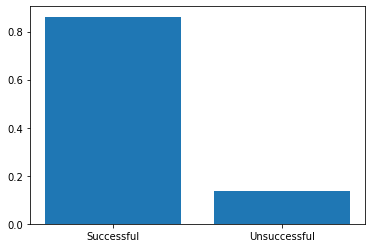

In [13]:
'''
# this colum will have five Succesful Loans too many because the Cancelled loans will be rolled into that category.
# 5 does not seem statistically significant, so at least for this stage, I don't think it matters
loans_to_2008['NewLoanStatus'] = np.where(loans_to_2008['LoanStatus'].isin(['ChargedOff', 'Defaulted']), 'Unsuccessful', 'Successful')


# find the total number of loans created from 2005 through 2008
total = loans_to_2008.NewLoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.NewLoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.NewLoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.bar(category, percentage)
'''

In [15]:
'''
successful = (loans_to_2008.NewLoanStatus == 'Successful').value_counts()/total
successful
'''

True     0.861922
False    0.138078
Name: NewLoanStatus, dtype: float64

I am going to combine the chargedoff and defaulted LoanStatus categories into a category called Unsuccessful. 

The completed loans I will call Successful.

In [6]:
# get current unique values
loans_to_2008['LoanStatus'].unique()

array(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'], dtype=object)

In [7]:
# create a dictionary so you can map the values onto the new category names

dict_map = dict(zip(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'], ['Successful', 'Unsuccessful', 'Unsuccessful', 'Cancelled']))
dict_map

{'Completed': 'Successful',
 'Chargedoff': 'Unsuccessful',
 'Defaulted': 'Unsuccessful',
 'Cancelled': 'Cancelled'}

In [8]:
# map the values into the new column

loans_to_2008['NewLoanStatus'] = loans_to_2008['LoanStatus'].map(dict_map)
loans_to_2008['NewLoanStatus'].value_counts()

Successful      18385
Unsuccessful    10666
Cancelled           5
Name: NewLoanStatus, dtype: int64

<AxesSubplot:xlabel='count', ylabel='NewLoanStatus'>

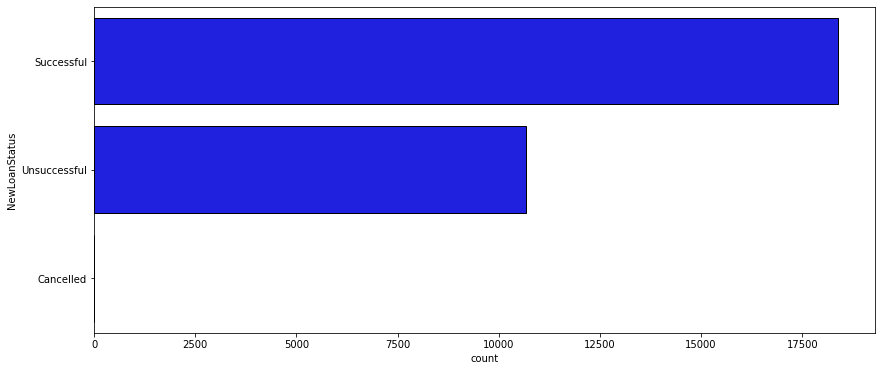

In [10]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loans_to_2008, y='NewLoanStatus', color='blue', edgecolor='black')

I want to look at the percentages of loans that ended up being either successful or unsuccessful.

<BarContainer object of 3 artists>

<Figure size 1008x432 with 0 Axes>

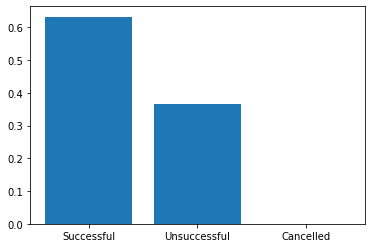

In [11]:
# find the total number of loans created from 2005 through 2008
total = loans_to_2008.NewLoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.NewLoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.NewLoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.bar(category, percentage)

In [12]:
total

29056

In [13]:
# the number of successful loans is 18385
# the number of total loans is 29056
18385/29056


0.6327436674008811

About 63% of the loans were successful.

I am now going to look at the distributions of a few of the metrics whose affect on loan outcomes I want to study.

First income ranges.

<AxesSubplot:xlabel='count', ylabel='IncomeRange'>

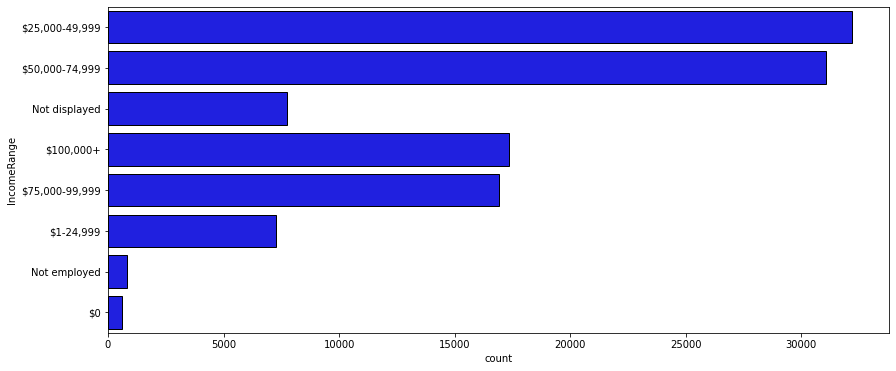

In [18]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loans_to_2008, y='IncomeRange', color='blue', edgecolor='black')


I want to put these columns in order from highest to lowest.

First I need to see all the column names clearly.

In [43]:
loan.groupby('IncomeRange').count()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
IncomeRange,,,,,,,,,,,,,,,,,,,,,
$0,621,621,621,576,621,621,606,621,621,621,...,621,621,621,621,621,621,621,621,621,621
"$1-24,999",7274,7274,7274,2607,7274,7274,4571,7274,7274,7274,...,7274,7274,7274,7274,7274,7274,7274,7274,7274,7274
"$100,000+",17337,17337,17337,2116,17337,17337,6064,17337,17337,17337,...,17337,17337,17337,17337,17337,17337,17337,17337,17337,17337
"$25,000-49,999",32192,32192,32192,7977,32192,32192,16344,32192,32192,32192,...,32192,32192,32192,32192,32192,32192,32192,32192,32192,32192
"$50,000-74,999",31050,31050,31050,5378,31050,31050,12789,31050,31050,31050,...,31050,31050,31050,31050,31050,31050,31050,31050,31050,31050
"$75,000-99,999",16916,16916,16916,2401,16916,16916,6442,16916,16916,16916,...,16916,16916,16916,16916,16916,16916,16916,16916,16916,16916
Not displayed,7741,7741,7741,7741,7741,7741,7741,7716,7741,7741,...,7741,7741,7741,7741,7741,7741,7741,7741,7741,7741
Not employed,806,806,806,157,806,806,532,806,806,806,...,806,806,806,806,806,806,806,806,806,806


Text(0, 0.5, 'Income Ranges')

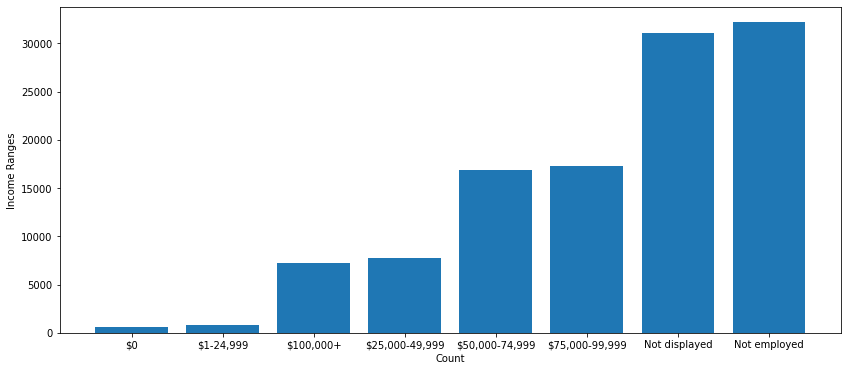

In [20]:

plt.figure(figsize=[14, 6])
x=sorted(list(loan['IncomeRange'].unique()))
y=sorted(loan['IncomeRange'].value_counts(sort=True))
plt.bar(x,y)
plt.xlabel('Count')
plt.ylabel('Income Ranges')

In [9]:
# checking to make sure the graphed values are correct
loans_to_2008['IncomeRange'].value_counts()

$25,000-49,999    8008
Not displayed     7741
$50,000-74,999    5412
$1-24,999         2617
$75,000-99,999    2417
$100,000+         2128
$0                 576
Not employed       157
Name: IncomeRange, dtype: int64

<AxesSubplot:>

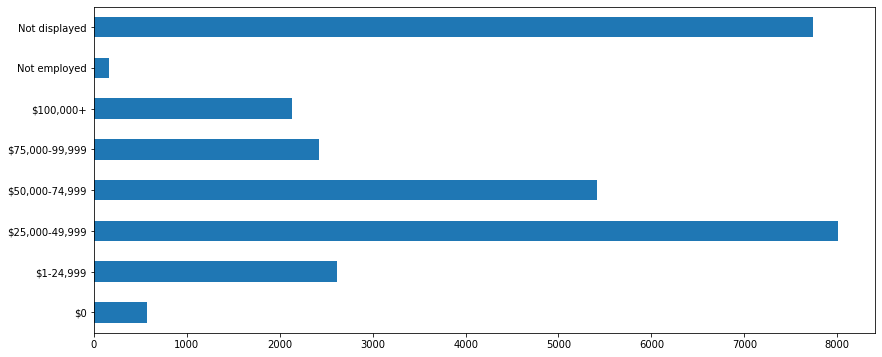

In [7]:
plt.figure(figsize=[14, 6])
order = ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+','Not employed', 'Not displayed']
loans_to_2008['IncomeRange'] = pd.Categorical(loans_to_2008['IncomeRange'], categories= order, ordered=True)
loans_to_2008['IncomeRange'].value_counts(sort=False).plot(kind='barh')

<AxesSubplot:>

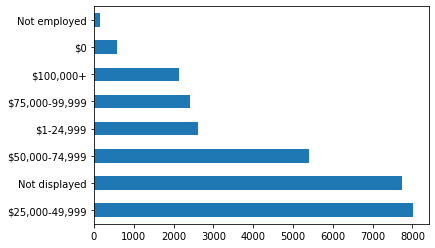

In [10]:
loans_to_2008['IncomeRange'].value_counts(sort=True).plot(kind='barh')

<AxesSubplot:>

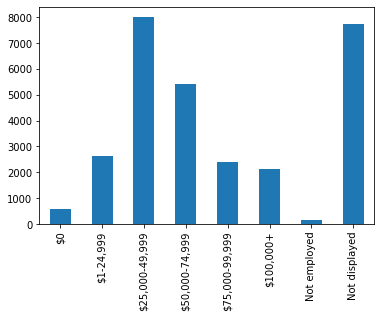

In [11]:
loans_to_2008['IncomeRange'].value_counts(sort=False).plot(kind='bar')

There's more loans for very-low income people then I'd thought there would be. It would be interesting to see how the percentage of loans given to people at various income levels relates to the percentage of people in the country at those various income ranges.

But that is outside the scope of this project.

We can say that there is a fair amount of data for all the income ranges (at least 2,000 loans for all categories except for the $0 income; and much more for people with low to medium incomes). Enough that the information should be statistically significant. I am surprised how many incomes were not recorded. I'm not sure what to do with that category.

Now let's look at credit grade distributions.

<AxesSubplot:xlabel='count', ylabel='CreditGrade'>

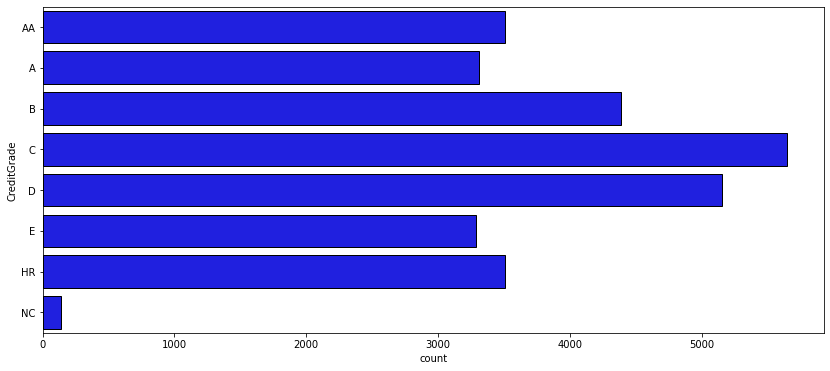

In [51]:
plt.figure(figsize=[14, 6])
order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR','NC']
sb.countplot(data=loans_to_2008, y='CreditGrade', color='blue', edgecolor='black', order=order)

In [52]:
loans_to_2008.CreditGrade.value_counts()

C     5644
D     5151
B     4386
HR    3508
AA    3508
A     3313
E     3289
NC     141
Name: CreditGrade, dtype: int64

In [53]:
loans_to_2008.CreditGrade.value_counts().sum()

28940

There seem to be a few less credit ratings than total loans.

I am surprised that the AA, A, and B credit ratings total about 13,000 loans.

If you add up the income levels from $50,000 to $100,000+, you get less than 10,000 total loans.

Of course there's the large "Not Displayed" section in the IncomeRange column. I may have to remove those people from the final analysis. It might make it difficult to speak meaningfully about income ranges in multivariate plots.

It is also interesting to see how willing Prosper is to loan to people with iff to very low credit ratings. C is the largest category, but D is the second largest category, and E is also pretty large.

I don't know what HR means.

I will now look at the counts for debt to income ratio.


(array([2.7324e+04, 1.3500e+02, 4.2000e+01, 2.7000e+01, 1.7000e+01,
        1.3000e+01, 5.0000e+00, 6.0000e+00, 2.0000e+00, 2.2800e+02]),
 array([ 0.   ,  1.001,  2.002,  3.003,  4.004,  5.005,  6.006,  7.007,
         8.008,  9.009, 10.01 ]),
 <BarContainer object of 10 artists>)

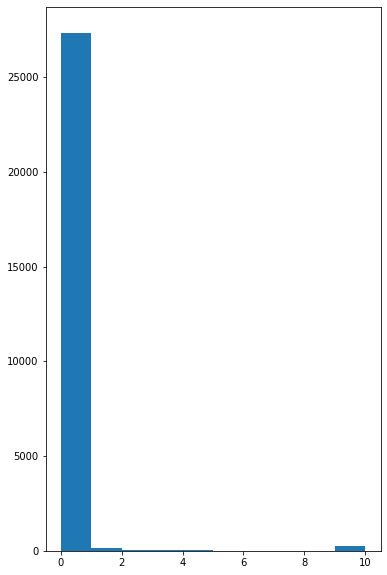

In [8]:
plt.figure(figsize=[6, 10])
#order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR','NC']
plt.hist(data = loans_to_2008, x='DebtToIncomeRatio')

Ratios above 1 are very rare. I guess those people are in a bad way.

Since they owe more than they make in a year.

It is weird that the largest outlier is like 9 to 10. Are we to believe there are people who owe ten times what they make in a year? And Prosper still gave them loans??

Let's zoom in to 0 to 1 range to see what kind of variation there is there.

(0.0, 2.0)

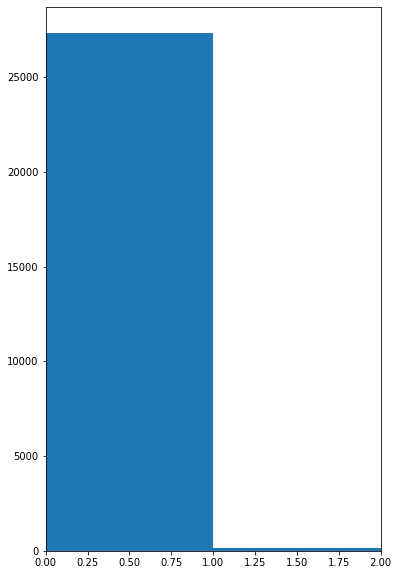

In [9]:
plt.figure(figsize=[6, 10])

plt.hist(data = loans_to_2008, x='DebtToIncomeRatio')

plt.xlim(0, 2)

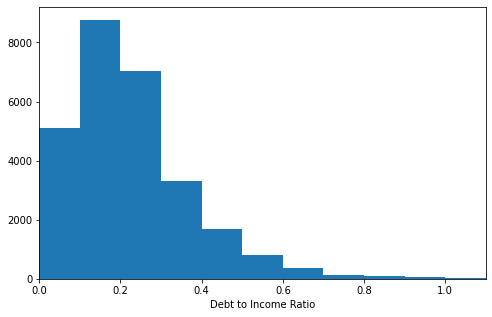

In [21]:
# I need to adjust the bin sizes

binsize = .1
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

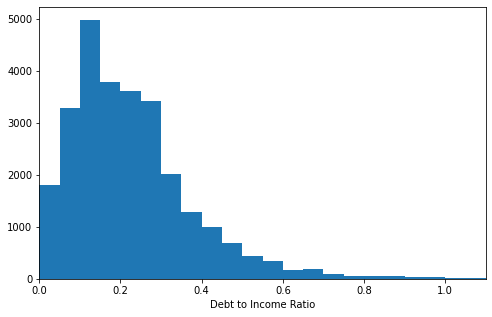

In [8]:

binsize = .05
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

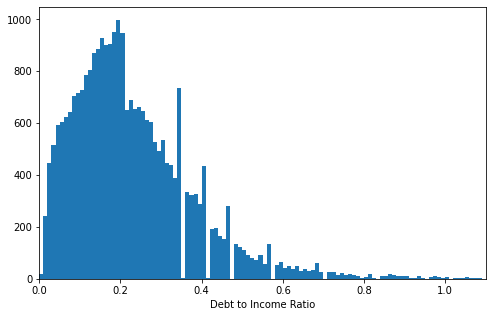

In [9]:
binsize = .01
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

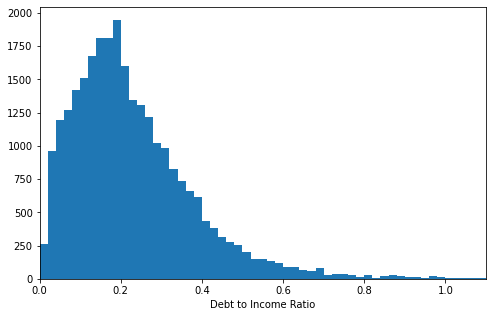

In [10]:
binsize = .02
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

The vast majority of the loans are given to people who's debt-to-income ratio is less than 1.

Of those, there are a lot of people with ratios from 0 to .1; but almost twice as many with ratios from .1 to .2; it tapers down from this height, with .3 having more loans than .1 but less than .2, and then a pretty quick drop-off.

This makes sense. Most people who need loans are exceeding their income at least somewhat. And I guess the bulk of them are living 20 to 30 percent above their means.

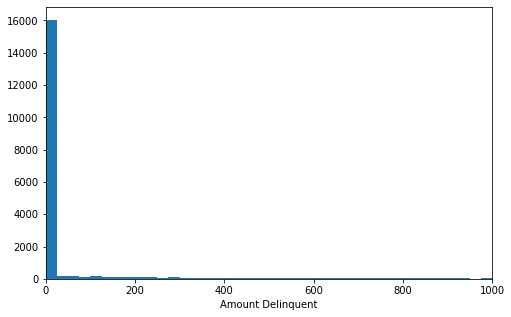

In [11]:
binsize = 25
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins = bins)
plt.xlabel('Amount Delinquent')
#plt.xticks(rotation)
plt.xlim(0, 1000)
plt.show()

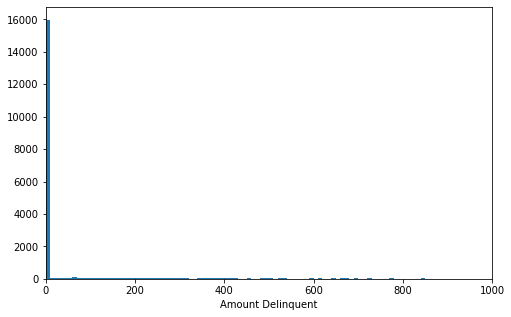

In [13]:
binsize = 10
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins = bins)
plt.xlabel('Amount Delinquent')
#plt.xticks(rotation)
plt.xlim(0, 1000)
plt.show()

The Amount Delinquent has an insanely long tale.

Most all of the amounts are around $100 or less.

But there are some that are more than $30K

I will try a log transformation.

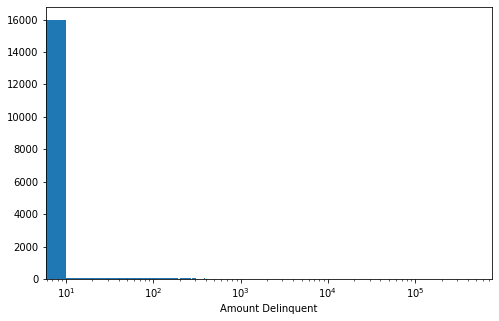

In [14]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

binsize = 10
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

#x_tick_locs = np.array([.1, .3, .5, .7, 1, 100, 300, 1000])

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins = bins)
plt.xlabel('Amount Delinquent')
plt.xscale('log')
#plt.xticks(log_trans(x_tick_locs), x_tick_locs)
#plt.xticks(rotation)
#plt.xlim(0, 1.1)
plt.show()

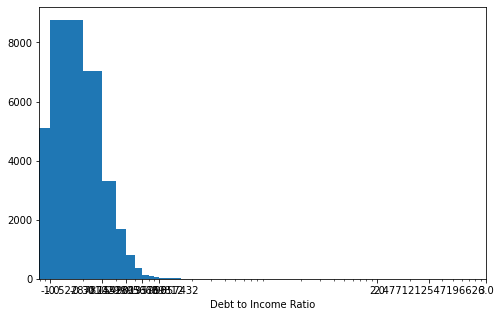

In [21]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

binsize = .1
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

x_tick_locs = np.array([.1, .3, .5, .7, 1, 100, 300, 1000])

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.xscale('log')
plt.xticks(x_tick_locs, log_trans(x_tick_locs))
#plt.xticks(rotation)
#plt.xlim(0, 1.1)
plt.show()

In [ ]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

binsize = .1
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

x_tick_locs = np.array([.1, .3, .5, .7, 1, 100, 300, 1000])

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.xscale('log')
plt.xticks(x_tick_locs, x_tick_locs)
#plt.xticks(rotation)
#plt.xlim(0, 1.1)
plt.show()

I think zooming in works just as good as a log transformation here.

Let's look at three categorical values: IsBorrowerHomeowner, BorrowerState, Occupation

<AxesSubplot:>

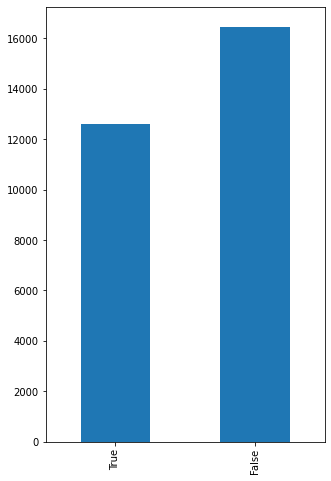

In [6]:
plt.figure(figsize=[5,8])

loans_to_2008['IsBorrowerHomeowner'].value_counts(sort=False).plot(kind='bar')

<AxesSubplot:>

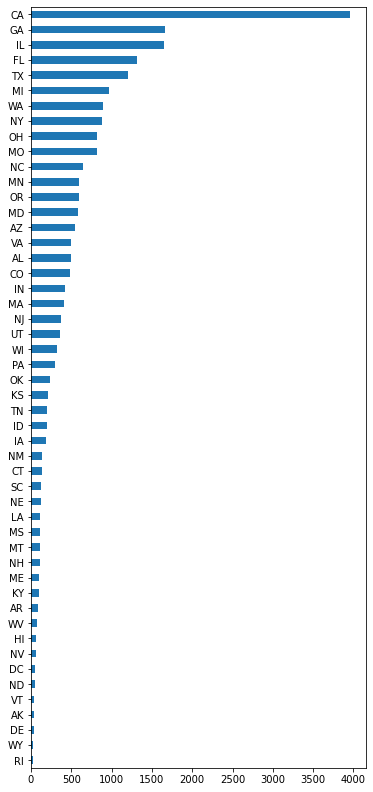

In [10]:
plt.figure(figsize=[6,14])

loans_to_2008['BorrowerState'].value_counts(sort=True, ascending=True).plot(kind='barh')

<AxesSubplot:>

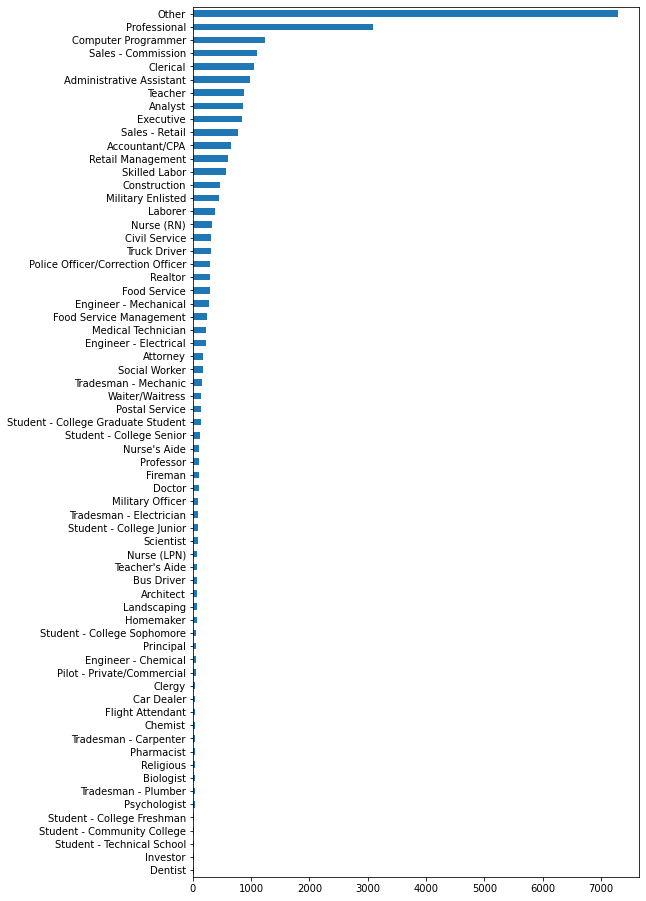

In [12]:
plt.figure(figsize=[8,16])

loans_to_2008['Occupation'].value_counts(sort=True, ascending=True).plot(kind='barh')

In [17]:
occupations = (loans_to_2008['Occupation'].value_counts(sort=True, ascending=False)).copy()
occupations.head(20)

Other                                7296
Professional                         3085
Computer Programmer                  1241
Sales - Commission                   1096
Clerical                             1047
Administrative Assistant              980
Teacher                               869
Analyst                               866
Executive                             843
Sales - Retail                        766
Accountant/CPA                        658
Retail Management                     601
Skilled Labor                         564
Construction                          464
Military Enlisted                     447
Laborer                               378
Nurse (RN)                            328
Civil Service                         317
Truck Driver                          308
Police Officer/Correction Officer     299
Name: Occupation, dtype: int64

Earlier I calculated that the success rate for the loans studied here (loans made from 2005 through 2008), was about 63%. That seems like a terrible failure rate, but I didn't factor in how much money the loans that were eventually defaulted or charged off had already paid back to the lender.

I think a better metric for measuring the success of the loans would be something like: (Amount Lendee paid Lender) - (Amount of Loan + Amount spent by Lendee in quest to recover Loan).

To that end, I will create the following column:

return on investment = (payments.sum - servicefees.sum - collectionfees.sum - loanamount + nonprincipalrecovery.sum + principalrecovery.sum)/loanamount


In [26]:
loans_to_2008.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29056 entries, 0 to 113927
Data columns (total 81 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   ListingKey                           29056 non-null  object        
 1   ListingNumber                        29056 non-null  int64         
 2   ListingCreationDate                  29056 non-null  datetime64[ns]
 3   CreditGrade                          28940 non-null  object        
 4   Term                                 29056 non-null  int64         
 5   LoanStatus                           29056 non-null  object        
 6   ClosedDate                           29056 non-null  object        
 7   BorrowerAPR                          29031 non-null  float64       
 8   BorrowerRate                         29056 non-null  float64       
 9   LenderYield                          29056 non-null  float64       
 10  Estimated

In [35]:
loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 
loans_to_2008.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,ROI
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,0.0,0.00,0.00,0.00,1.0,0,0,0.0,258,0.223270
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,0.0,0.00,0.00,0.00,1.0,0,0,0.0,41,0.403142
11,0F1734025150298088A5F2B,213551,2007-10-09 20:28:33.640,C,36,Completed,2008-01-07 00:00:00,0.15033,0.1325,0.1225,...,0.0,0.00,0.00,0.00,1.0,0,0,0.0,53,0.012530
17,0FDF336575182398852A8DC,31540,2006-08-15 12:21:09.433,AA,36,Chargedoff,2008-05-22 00:00:00,0.13202,0.1250,0.1175,...,0.0,6012.65,6012.67,268.96,1.0,0,0,0.0,85,-0.435110
21,1017340630713945364DA6B,241498,2007-11-30 20:33:49.227,D,36,Completed,2010-12-12 00:00:00,0.21488,0.2075,0.1975,...,0.0,0.00,0.00,0.00,1.0,0,0,0.0,53,0.370723


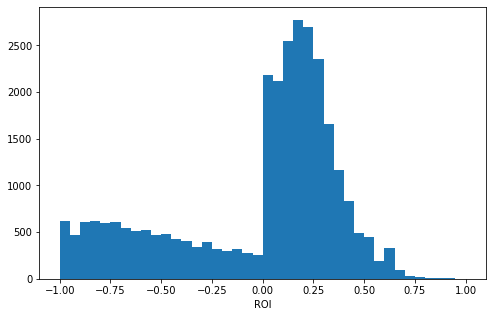

In [7]:
binsize = .05
bins = np.arange(-1.05, loans_to_2008['ROI'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'ROI', bins = bins)
plt.xlabel('ROI')
#plt.xticks(rotation)
plt.xlim(-1.1,1.1)
plt.show()

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

My focus is on whether or not a loan was successful. 

I limited the loans to those begun on or prior to 2008, because I calculated that those loans should be completed by the time that they stopped adding data to the dataframe. That way I can see what percentage of loans that should've been paid off were indeed paid off.

The variable of interest for this research is LoanStatus.

However, of the four categories of LoanStatus that occur in the data prior to 2009, two (ChargedOff and Defaulted) seem to me to be clearly unsuccessful, and one (Completed) as clearly successful. One (Cancelled) I am not sure how to assess, and there only five rows in the entire dataset with this outcome. Accordingly, I created a new variable NewLoanStatus with two categories: Successful for Completed and Unsuccessful for ChargedOff and Defaulted.

This is the breakdown for each category:

Completed - 18385 / Chargedoff - 6654 / Defaulted - 4012 / Cancelled - 5

Which results in:

Successful - 18,385 / Unsuccessful - 10664 / Total - 29,056

That's a success rate of 18385/29056 = 63%

I would've thought the success rate would be much higher than that.

How can a lender stay in business with this kind of a success rate?

The graph was of course straight-forward. There was no need for transformations.

But I wasn't sure that this was an adequate metric for analyzing the success of the loans. For one thing, these calculations don't account for how much money was recovered in the "Unsuccessful" loans. Both a loan that paid the principal and a small portion of the interest and a loan that didn't pay anything at all would be labelled "Unsuccessfull", but the former hypothetical loan is much more successful than the latter one.

So I decided to look at return on investment, calculated like this:

loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 


With that metric, I saw that the bulk of the loans had an ROI between 0+ (a touch above 0)  and .3,and then tapered down to .75, with only a very few loans doing better than that on the positive side. The negative side had much less values, but they were much more uniform than the positive values. About 250 loans had an ROI of 0, and then the trend is a gradual slope upward until -1, where there are about 500 loans that I guess you could characterize as complete disasters.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Income Range: Nothing shocking here. By far the most loans went to people making between $25K and $50K; with the $50 to $75K range accounting for about 3/4 as many borrowers as the $25-$50K range, and people making more or less than $25-$75k accounting for about 1/4 as many loans as the $25-$50K group. The graph was straight forward. No transforamtions were needed.

Debt To Income: Values generally between 0 and 1. The best graph was at bin sizes of .02. Right skewed, concave to the right, convex to the left. A fairly long tail, but I didn't see a reason to do a log transformation -- the values (between 0 and 1.5) seemed too circumstribed for that. The highpoint was around .2, and there was a lot more variety to the values greater than .2 than to the values less than .2

Amount Delinquent: This one is boring. Almost everyone owed like less than $50. I did a log transformation since it had such a long tale

Credit Grade: Straight forward graphs, but I was surprised at how many loans they gave to people with lower credit raitings. C was the most common rating, but D was almost as common as C, and there were a lot of loans given to people with even lower credit ratings.

Borrower State: Pretty straightforward graphs. I was surprised a little by the states that had the most borrowers. California had by far the most. That wasn't too surprising, since it is such a populous state. But the second most borrowers were in Georgia, and then Illinois. Those are large states, but Georgia particularly is nowhere near number 2 in population. I guess this has somethign to do with the states where Prosper had the largest presence during the time period we're analysing.

Occupation: I don't know how useful this one can be. By far the largest category is "Other" $7K+), and then the very vague "Professional" ($3K+). Then there are only three with at least $1K, and one of them is the still very vague "Clerical".

Home Owner: Straight forward. There's about 20% people who don't own homes than who do.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!